<a href="https://colab.research.google.com/github/hoangDEVteams/deeplearning/blob/main/SalaryModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

Nhập và kiểm tra dữ liệu

In [53]:
uploaded = files.upload()

In [54]:
df = pd.read_csv('Salary_Data.csv')
df.head()
print(df)

    YearsExperience    Salary
0               1.1   39343.0
1               1.3   46205.0
2               1.5   37731.0
3               2.0   43525.0
4               2.2   39891.0
5               2.9   56642.0
6               3.0   60150.0
7               3.2   54445.0
8               3.2   64445.0
9               3.7   57189.0
10              3.9   63218.0
11              4.0   55794.0
12              4.0   56957.0
13              4.1   57081.0
14              4.5   61111.0
15              4.9   67938.0
16              5.1   66029.0
17              5.3   83088.0
18              5.9   81363.0
19              6.0   93940.0
20              6.8   91738.0
21              7.1   98273.0
22              7.9  101302.0
23              8.2  113812.0
24              8.7  109431.0
25              9.0  105582.0
26              9.5  116969.0
27              9.6  112635.0
28             10.3  122391.0
29             10.5  121872.0


Tách feature – target

In [55]:
X = df[['YearsExperience']]
Y = df[['Salary']]

Chia train/test

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Baseline Linear Regression

In [57]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

Đánh giá trên test-set

In [58]:
y_pred = model.predict(X_test)

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2  = r2_score(Y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

MSE: 24691504.94
MAE: 3914.37
R²: 0.9377


Trực quan hóa

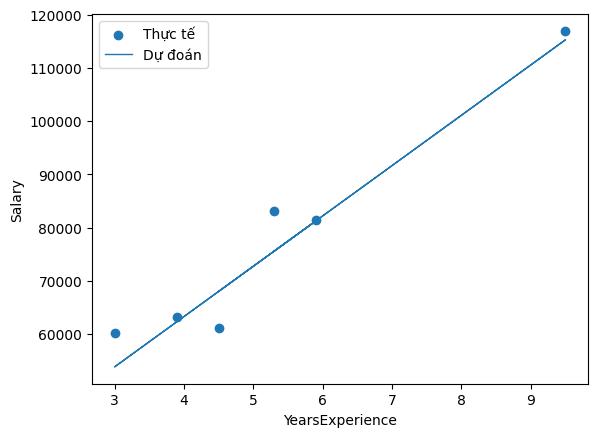

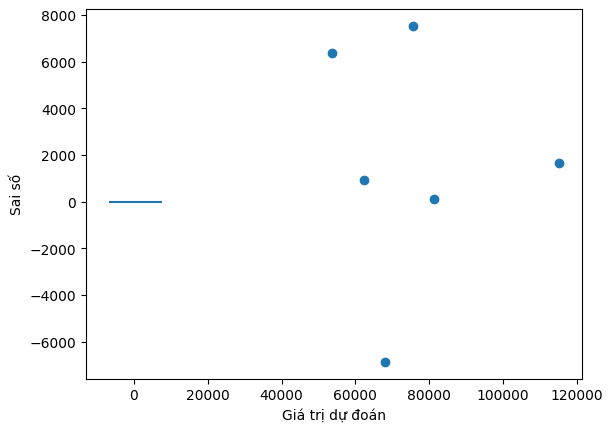

In [60]:
import matplotlib.pyplot as plt

# 2.1 Scatter thực tế vs dự đoán
plt.scatter(X_test, Y_test, label="Thực tế")
plt.plot(X_test, y_pred, label="Dự đoán", linewidth=1)
plt.xlabel("YearsExperience"); plt.ylabel("Salary")
plt.legend(); plt.show()

# 2.2 Residual plot
residuals = Y_test.values.flatten() - y_pred.flatten()
plt.scatter(y_pred, residuals)
plt.hlines(0, residuals.min(), residuals.max())
plt.xlabel("Giá trị dự đoán"); plt.ylabel("Sai số"); plt.show()


Cross-validation cơ bản

In [61]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, Y, cv=5, scoring="neg_mean_squared_error")
print("CV MSE trung bình:", -scores.mean())

CV MSE trung bình: 44168849.46887096


K-Fold chi tiết

In [62]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, Y, cv=kf, scoring="neg_mean_squared_error")
mse_scores = -scores
print("MSE từng fold:", np.round(mse_scores, 2))
print("Mean:", np.round(mse_scores.mean(),2), "Std:", np.round(mse_scores.std(),2))

MSE từng fold: [49830096.86 33108594.81 33862703.49 12750944.93 39326046.04]
Mean: 33775677.22 Std: 12091674.2


Phân tích residual chi tiết

In [63]:
# Chuẩn bị mảng 1D
years     = X_test.values.flatten()      # hoặc X_test['YearsExperience'].values
actual    = Y_test.values.flatten()
predicted = y_pred.flatten()

# Xây DataFrame
df_res = pd.DataFrame({
    'YearsExperience': years,
    'Actual':           actual,
    'Predicted':        predicted
})
# Tính residual và sắp theo |residual| giảm dần
df_res['Residual'] = df_res['Actual'] - df_res['Predicted']
df_res = df_res.reindex(df_res['Residual'].abs().sort_values(ascending=False).index)

print(df_res)


   YearsExperience    Actual      Predicted     Residual
5              5.3   83088.0   75551.854494  7536.145506
0              4.5   61111.0   67979.917423 -6868.917423
2              3.0   60150.0   53782.535414  6367.464586
1              9.5  116969.0  115304.524120  1664.475880
3              3.9   63218.0   62300.964619   917.035381
4              5.9   81363.0   81230.807298   132.192702


In [64]:
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor().fit(X_train, Y_train.values.ravel())
y_hub = huber.predict(X_test)
print("Huber MSE:", mean_squared_error(Y_test, y_hub))

Huber MSE: 27607454.255660444


So sánh mô hình qua RepeatedKFold

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Chuyển Y thành 1d array để tránh DataConversionWarning
y1d = Y.values.ravel()

# 1) Cross-validation ổn định với nhiều lần lặp
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
cv_mse = -cross_val_score(model, X, y1d, cv=rkf, scoring="neg_mean_squared_error")
cv_mae = -cross_val_score(model, X, y1d, cv=rkf, scoring="neg_mean_absolute_error")
print(f"Linear CV MSE: {cv_mse.mean():.2f} ± {cv_mse.std():.2f}")
print(f"Linear CV MAE: {cv_mae.mean():.2f} ± {cv_mae.std():.2f}")

# 2) So sánh với Polynomial (degree=2)
poly = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_mse = -cross_val_score(poly, X, y1d, cv=rkf, scoring="neg_mean_squared_error")
poly_mae = -cross_val_score(poly, X, y1d, cv=rkf, scoring="neg_mean_absolute_error")
print(f"Poly2 CV MSE: {poly_mse.mean():.2f} ± {poly_mse.std():.2f}")
print(f"Poly2 CV MAE: {poly_mae.mean():.2f} ± {poly_mae.std():.2f}")

# 3) So sánh với RandomForest
rf = RandomForestRegressor(random_state=42)
rf_mse = -cross_val_score(rf, X, y1d, cv=rkf, scoring="neg_mean_squared_error")
rf_mae = -cross_val_score(rf, X, y1d, cv=rkf, scoring="neg_mean_absolute_error")
print(f"RF CV MSE: {rf_mse.mean():.2f} ± {rf_mse.std():.2f}")
print(f"RF CV MAE: {rf_mae.mean():.2f} ± {rf_mae.std():.2f}")


Linear CV MSE: 35707117.55 ± 14863456.83
Linear CV MAE: 4980.97 ± 1308.42
Poly2 CV MSE: 38400646.29 ± 15627053.21
Poly2 CV MAE: 5176.75 ± 1307.39
RF CV MSE: 38274715.79 ± 16475829.69
RF CV MAE: 5226.31 ± 1125.00


Tuning Ridge & Lasso

In [66]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

y1d = Y.values.ravel()

# Ridge
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(Ridge(), ridge_params,
                        scoring='neg_mean_squared_error',
                        cv=rkf)
ridge_cv.fit(X, y1d)
print("Ridge best α:", ridge_cv.best_params_['alpha'],
      "→ CV MSE:", -ridge_cv.best_score_)

# Lasso
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(Lasso(max_iter=10000), lasso_params,
                        scoring='neg_mean_squared_error',
                        cv=rkf)
lasso_cv.fit(X, y1d)
print("Lasso best α:", lasso_cv.best_params_['alpha'],
      "→ CV MSE:", -lasso_cv.best_score_)


Ridge best α: 1 → CV MSE: 35677075.35000151
Lasso best α: 1 → CV MSE: 35707012.060344346


Final train & test

In [67]:
import joblib
best = Ridge(alpha=1).fit(X, y1d)
joblib.dump(best, 'salary_ridge.pkl')

['salary_ridge.pkl']

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# 1) Chia dữ liệu rõ ràng
X_train, X_test, y_train, y_test = train_test_split(
    X, Y.values.ravel(), test_size=0.2, random_state=42
)

# 2) Train Ridge(α=1) trên X_train
model = Ridge(alpha=1)
model.fit(X_train, y_train)

# 3) Đánh giá trên X_test
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.4f}")

# 4) Nếu đạt yêu cầu thì refit trên toàn bộ data và lưu model
final_model = Ridge(alpha=1).fit(X, Y.values.ravel())
joblib.dump(final_model, 'salary_ridge.pkl')


Test MSE: 49974852.72
Test MAE: 6274.69
Test R²: 0.9022


['salary_ridge.pkl']

In [69]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Định nghĩa lại pipeline poly
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lr',   LinearRegression())
])
# 2. Train trên X_train
poly_pipeline.fit(X_train, y_train)
# 3. Dự đoán và đánh giá trên X_test
y_poly_test = poly_pipeline.predict(X_test)
print("Poly2 Test MSE:", mean_squared_error(y_test, y_poly_test))
print("Poly2 Test MAE:", mean_absolute_error(y_test, y_poly_test))
print("Poly2 Test R²:", r2_score(y_test, y_poly_test))


Poly2 Test MSE: 52527916.36877497
Poly2 Test MAE: 6381.371429702194
Poly2 Test R²: 0.897164578089087


In [70]:
from fastapi import FastAPI
import joblib
import numpy as np

app = FastAPI()
model = joblib.load('salary_ridge.pkl')

@app.get("/predict/")
def predict(exp: float):
    salary = model.predict(np.array([[exp]]))[0]
    return {"YearsExperience": exp, "PredictedSalary": round(salary,2)}
